## **영상 증강 (Image Augmentation)**

In [73]:
import os
import random
import torch
import requests
import numpy as np
import pickle as pkl
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms

In [28]:
server_url = 'http://dmlab.kaist.ac.kr/~geonlee/1300_1500/'

### 데이터 로드

In [38]:
# 데이터 정보 읽어오기
with open('data_list.pkl', 'rb') as f:
    data_list = pkl.load(f)
    
with open('date_list.pkl', 'rb') as f:
    date_list = pkl.load(f)

### 임의의 랜덤 이미지 추출
index 변수를 조절해서 직접 조절 가능 (범위: 0 ~ 279,176)

In [64]:
# 임의의 이미지 추출
index = random.sample(range(len(data_list)), 1)[0]
img_url = os.path.join(server_url, data_list[index])
img_date = date_list[index]
print('Date:', img_date)

Date: 2020-01-07 08:45:00


### 원본 이미지 출력

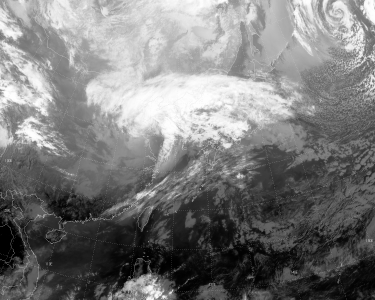

In [82]:
# 원본 이미지 출력
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
display(img)

### **증강 방법 1: 픽셀 맞바꾸기 (Swap)**
swap_ratio를 통해 전체 픽셀의 맞바꾸기 비율을 조절.

In [98]:
# 픽셀 맞바꾸기 (swapping) 함수
def augmentation_swap(img, swap_ratio=0.01):
    h, w = img.shape
    i = torch.arange(h).repeat_interleave(w)
    j = torch.arange(w).repeat(h)
    k = torch.arange(h * w)
    
    p = torch.randint(h * w, (int(h * w * swap_ratio),1))
    q = torch.randint(h * w, (int(h * w * swap_ratio),1))
    kp, kq = k[p], k[q]
    k[p], k[q] = kq, kp
    
    i = i[k].view(h, w)
    j = j[k].view(h, w)
    img = img[i,j]
    return img

##### swap_ratio$=0.01$인 경우

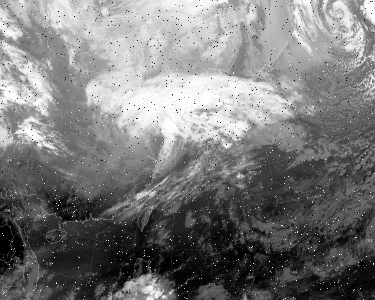

In [100]:
img_mat = transforms.ToTensor()(img).squeeze(0)
aug_img_mat = augmentation_swap(img_mat, 0.01)
aug_img = transforms.ToPILImage()(aug_img_mat)
display(aug_img)

##### swap_ratio$=0.05$인 경우

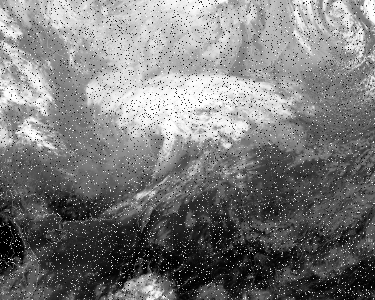

In [101]:
img_mat = transforms.ToTensor()(img).squeeze(0)
aug_img_mat = augmentation_swap(img_mat, 0.05)
aug_img = transforms.ToPILImage()(aug_img_mat)
display(aug_img)

### **증강 방법 2: 위치 옮기기 (Shift)**
이미지를 상하좌우로 평행이동.

In [113]:
# 위치 옮기기 (shifting) 함수
def augmentation_shift(img, max_shift=50):
    aug_img = torch.zeros_like(img)
    
    shift_h, shift_w = 0, 0
    while (shift_h == 0) or (shift_w == 0):
        shift_h = torch.randint(-max_shift, max_shift, (1,))[0].item()
        shift_w = torch.randint(-max_shift, max_shift, (1,))[0].item()
    
    shift_h_size = abs(shift_h)
    shift_w_size = abs(shift_w)
    blanked_row = img[shift_h:,:] if shift_h < 0 else img[:shift_h,:]
    blanked_col = img[:,shift_w:] if shift_w < 0 else img[:,:shift_w]
    
    avg_row = torch.mean(blanked_row, dim=0).repeat(shift_h_size).view(shift_h_size,-1)
    avg_col = torch.mean(blanked_col, dim=1).view(-1,1).repeat(1,shift_w_size).view(-1,shift_w_size)
    avg_inter_row = avg_row[:,shift_w:] if shift_w < 0 else avg_row[:,:shift_w]
    avg_inter_col = avg_col[shift_h:,:] if shift_h < 0 else avg_col[:shift_h,:]
    avg_inter = (avg_inter_row + avg_inter_col) / 2
    
    aug_img = torch.roll(img, shifts=(shift_h, shift_w), dims=(0,1))
    replaced_row = aug_img[shift_h:,:] if shift_h < 0 else aug_img[:shift_h,:]
    replaced_col = aug_img[:,shift_w:] if shift_w < 0 else aug_img[:,:shift_w]
    replaced_inter = replaced_row[:,shift_w:] if shift_w < 0 else replaced_row[:,:shift_w]
    
    replaced_row[:,:] = avg_row[:,:]
    replaced_col[:,:] = avg_col[:,:]
    replaced_inter[:,:] = avg_inter[:,:]
    
    return aug_img

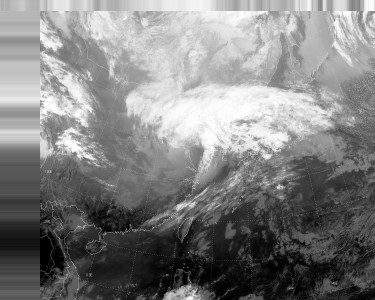

In [114]:
img_mat = transforms.ToTensor()(img).squeeze(0)
aug_img_mat = augmentation_shift(img_mat)
aug_img = transforms.ToPILImage()(aug_img_mat)
display(aug_img)

### **증강 방법 3: 명암 조절 증강**
$p$가 이미지의 각 픽셀 값(0~1)일때, $p$를 다음 함수로 변환.
$$1-\left(1-p^n\right)^{\frac{1}{n}}$$
$n$을 통해 명암 조절 가능 ($n=1$일때는 변환 효과 없음).

In [65]:
# 명암 조절 함수
def augmentation_brightness(img, n):
    return 1 - (1 - img**n)**(1/n)

##### $n=0.5$인 경우

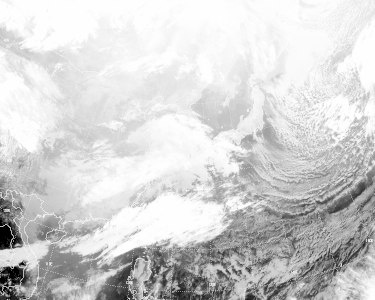

In [59]:
n = 0.5

img_mat = transforms.ToTensor()(img).squeeze(0)
aug_img_mat = augmentation_brightness(img_mat, n)
aug_img = transforms.ToPILImage()(aug_img_mat)
display(aug_img)

##### $n=2.0$인 경우

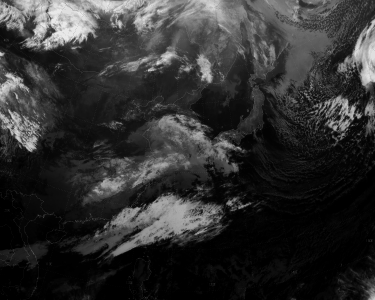

In [60]:
n = 2.0

img_mat = transforms.ToTensor()(img).squeeze(0)
aug_img_mat = augmentation_brightness(img_mat, n)
aug_img = transforms.ToPILImage()(aug_img_mat)
display(aug_img)